In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.figsize"] = (40, 5)

from typeguard import typechecked

from numpy import datetime64
from pandas import Timestamp, Timedelta
from datetime import datetime, timedelta
from pvlib import location
from pytz import timezone

from lib.utils import (
    get_irradiance,
    integrate,
    open_forecast_files,
    plot_radiation_and_irradiance,
)
from lib.boat_model import Boat, Panel, Battery, Other, ESC, Motor, Propulsion, Hull
from lib.event_model import (
    Event,
    EventInputData,
    EventResultData,
    EventResultDataSet,
    FixedLapsGoal,
    RaceStatus,
)
from lib.boat_data import (
    BoatInputData,
    BoatInputDataSet,
    BoatOutputData,
    BoatOutputDataSet,
)
from lib.energy_controller_model import EnergyController
from lib.competition_model import Competition


In [2]:
# Create solar dataset
site = location.Location(
    latitude=-22.924247,
    longitude=-43.097405,
    tz="America/Sao_Paulo",
    altitude=0,
    name="Niterói",
)

description = {
    "time": {
        "start": "2022-03-16",
        "end": "2022-03-23",
        "freq": "1min",
    },
}

clearsky_data =  pd.DataFrame(site.get_clearsky(
    pd.date_range(
        start=description["time"]["start"],
        end=description["time"]["end"],
        freq=description["time"]["freq"],
        tz=site.tz,
    )
))

clearsky_data["poa"] = get_irradiance(
    site_location=site,
    tilt=0,
    surface_azimuth=0,
    weather_data=clearsky_data,
)

clearsky_data = clearsky_data[description["time"]["start"] : description["time"]["end"]]

clearsky_data["Solar Energy"] = integrate(clearsky_data, 3600)["poa"]


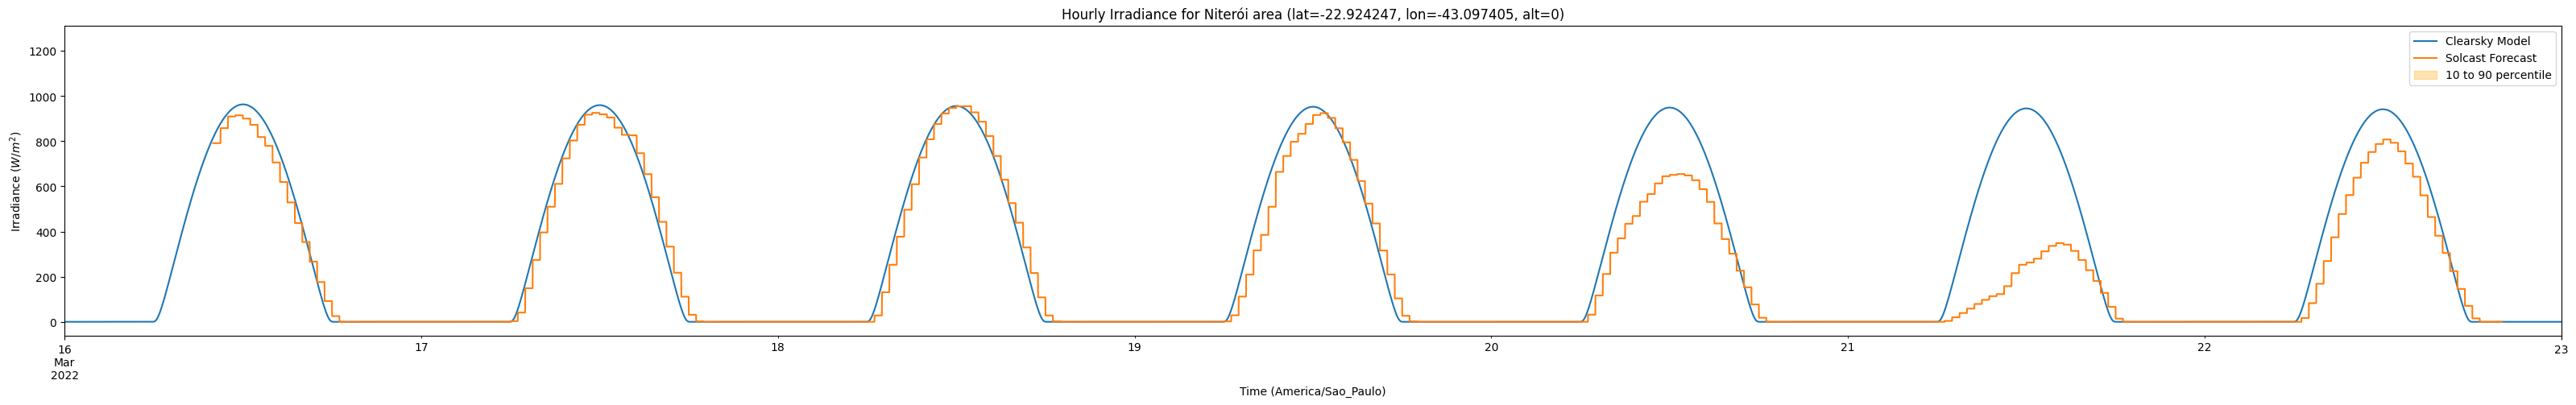

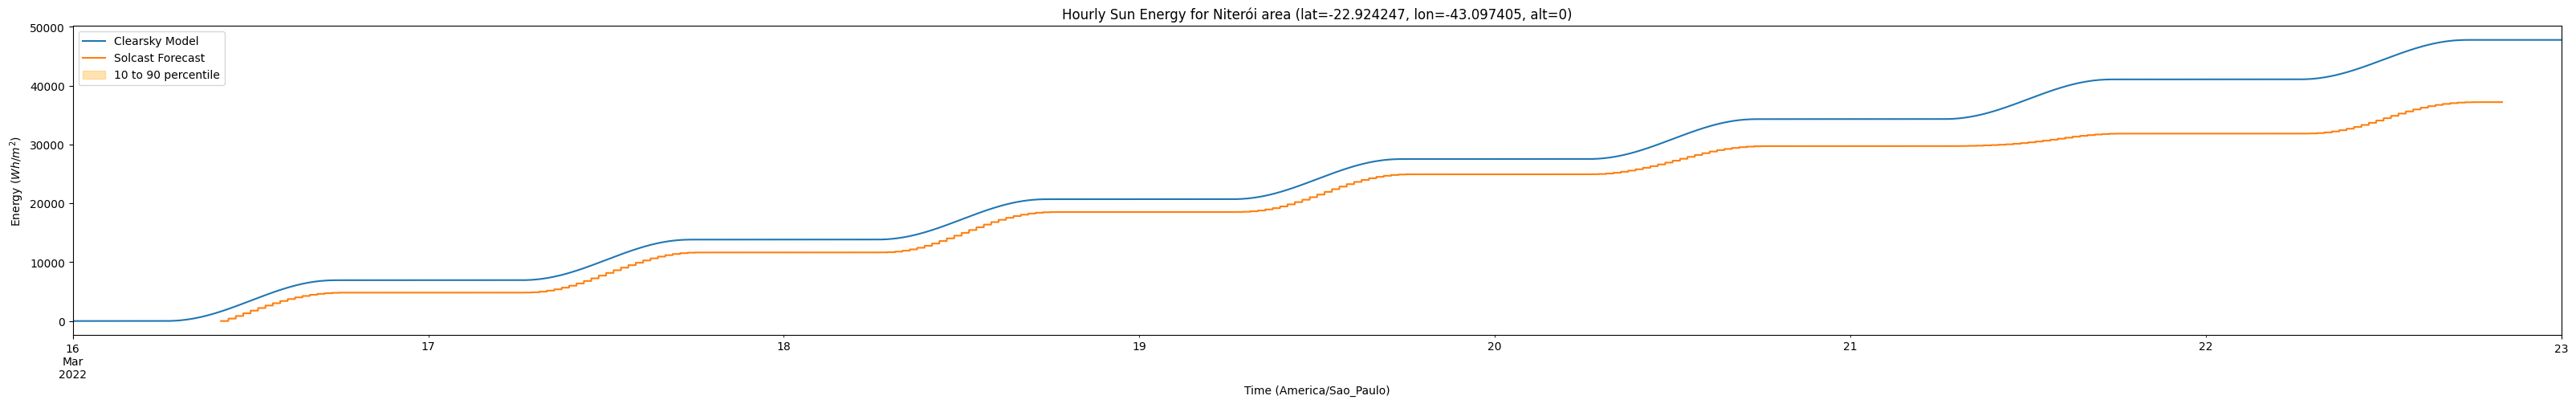

In [3]:
path = "/home/joaoantoniocardoso/ZeniteSolar/2022/Strategy22"

forecast_files = [
    # f"{path}/datasets/solcast_forecast_14032022_1955.csv",
    f"{path}/datasets/solcast_forecast_16032022_0947.csv",
    f"{path}/datasets/solcast_forecast_17032022_0522.csv",
    f"{path}/datasets/solcast_forecast_17032022_0948.csv",
    f"{path}/datasets/solcast_forecast_17032022_1338.csv",
    f"{path}/datasets/solcast_forecast_17032022_1519.csv",
    f"{path}/datasets/solcast_forecast_18032022_0916.csv",
    f"{path}/datasets/solcast_forecast_18032022_1208.csv",
    f"{path}/datasets/solcast_forecast_18032022_1535.csv",
    f"{path}/datasets/solcast_forecast_19032022_0141.csv",
    f"{path}/datasets/solcast_forecast_19032022_0554.csv",
    f"{path}/datasets/solcast_forecast_19032022_0906.csv",
    f"{path}/datasets/solcast_forecast_19032022_1555.csv",
    f"{path}/datasets/solcast_forecast_20032022_0618.csv",
    f"{path}/datasets/solcast_forecast_20032022_1300.csv",
    f"{path}/datasets/solcast_forecast_21032022_0057.csv",
    f"{path}/datasets/solcast_forecast_21032022_1901.csv",
]

real_data = open_forecast_files(forecast_files, description)

real_data.drop(columns=["Period"], inplace=True)
real_data.columns = real_data.columns.str.lower()
real_data.rename(
    columns={"cloudopacity": "Cloud Opacity", "airtemp": "Air Temp"}, inplace=True
)
real_data.index = pd.to_datetime(real_data.index).tz_convert(site.tz)  # type: ignore
freq = pd.infer_freq(real_data.index)
if freq is None:
    raise Exception("Failed infering frequency!")
real_data.index.freq = freq

real_data10 = real_data[["ghi10", "dni10", "dhi"]].rename(
    columns={"ghi10": "ghi", "dni10": "dni"}
)
real_data90 = real_data[["ghi90", "dni90", "dhi"]].rename(
    columns={"ghi90": "ghi", "dni90": "dni"}
)

real_data["poa"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data
)
real_data["poa10"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data10
)
real_data["poa90"] = get_irradiance(
    site_location=site, tilt=0, surface_azimuth=0, weather_data=real_data90
)

real_data = real_data[description["time"]["start"] : description["time"]["end"]]

real_data["Solar Energy"] = integrate(real_data, 3600)["poa"]
real_data["Solar Energy10"] = integrate(real_data, 3600)["poa10"]
real_data["Solar Energy90"] = integrate(real_data, 3600)["poa90"]

real_data = real_data.resample("10s").ffill()

plot_radiation_and_irradiance(clearsky_data, real_data, site)


In [4]:
# Select the input data
from dataclasses import dataclass


input_data = BoatInputDataSet(
    {
        "time": pd.DatetimeIndex(real_data.index).tz_convert(None).to_numpy(),
        "poa": real_data["poa"].to_numpy(),
    }
)

# Create the competition
tzinfo = timezone(site.tz)
competition = Competition(
    name="DSB 2022 - Etapa Niterói",
    events=[
        Event(
            EventInputData(
                name="Match Race Qualifiers",
                description="Classificatórias da prova 1x1",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=786.73,
                    total_time=Timedelta(timedelta(hours=1)),
                ),
                start=Timestamp(year=2022, month=3, day=17, hour=9, minute=30, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=17, hour=10, minute=30, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Match Race",
                description="Prova 1x1",
                goal=FixedLapsGoal(
                    total_laps=1,
                    lap_distance=786.73,
                    total_time=Timedelta(timedelta(hours=2)),
                ),
                start=Timestamp(year=2022, month=3, day=17, hour=14, minute=00, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=17, hour=16, minute=00, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        Event(
            EventInputData(
                name="Long Race 1",
                description="Prova longa",
                goal=FixedLapsGoal(
                    total_laps=3,
                    lap_distance=7081.987,
                    total_time=Timedelta(hours=5),
                ),
                start=Timestamp(year=2022, month=3, day=18, hour=11, minute=00, tzinfo=tzinfo).tz_convert(None),
                end=Timestamp(year=2022, month=3, day=18, hour=16, minute=00, tzinfo=tzinfo).tz_convert(None),
            )
        ),
        # Event(
        #     EventInputData(
        #         name="Relay Race",
        #         description="Prova de revezamento de pilotos",
        #         goal=FixedLapsGoal(
        #             total_laps=2,
        #             lap_distance=812.19,
        #             total_time=Timedelta(timedelta(hours=3)),
        #         ),
        #         start=Timestamp(year=2022, month=3, day=19, hour=9, minute=30, tzinfo=tzinfo).tz_convert(None),
        #         end=Timestamp(year=2022, month=3, day=19, hour=12, minute=30, tzinfo=tzinfo).tz_convert(None),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Short Race 1",
        #         description="Prova curta",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=4678.39,
        #             total_time=Timedelta(timedelta(hours=2)),
        #         ),
        #         start=Timestamp(year=2022, month=3, day=20, hour=11, minute=30, tzinfo=tzinfo).tz_convert(None),
        #         end=Timestamp(year=2022, month=3, day=20, hour=13, minute=30, tzinfo=tzinfo).tz_convert(None),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Quick Race 1",
        #         description="Prova rápida",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=4678.39,
        #             total_time=Timedelta(timedelta(hours=1)),
        #         ),
        #         start=Timestamp(year=2022, month=3, day=20, hour=9, minute=30, tzinfo=tzinfo).tz_convert(None),
        #         end=Timestamp(year=2022, month=3, day=20, hour=10, minute=30, tzinfo=tzinfo).tz_convert(None),
        #     )
        # ),
        # Event(
        #     EventInputData(
        #         name="Sprint Race",
        #         description="Prova de arrancada",
        #         goal=FixedLapsGoal(
        #             total_laps=1,
        #             lap_distance=1057.03,
        #             total_time=Timedelta(timedelta(hours=1.5)),
        #         ),
        #         start=Timestamp(year=2022, month=3, day=22, hour=10, minute=30, tzinfo=tzinfo).tz_convert(None),
        #         end=Timestamp(year=2022, month=3, day=22, hour=12, minute=00, tzinfo=tzinfo).tz_convert(None),
        #     )
        # ),
    ],
)


# Create the boat
boat = Boat(
    panel=Panel(efficiency=0.16*0.9, maximum_output_power=(4 * 300), area=(4 * 1.6 * 1.0)),
    battery=Battery(
        efficiency=0.8,
        soc_0=0.95,
        minimum_soc=0.05,
        maximum_energy=1500,
        maximum_power=10000,
    ),
    circuits=Other(power=(18 * 3.0)),
    esc=ESC(
        efficiency=0.85,
        maximum_input_power=5000,
    ),
    motor=Motor(efficiency=0.85, maximum_input_power=150.0*36.0),
    propulsion=Propulsion(
        efficiency=0.7,
        maximum_input_power=10000,
    ),
    hull=Hull(speed_over_power_constant=0.097, exponential_factor=0.584),
)


from strictly_typed_pandas.dataset import DataSet


@dataclass
class PredictionData:
    time: datetime64
    poa: float
    poa10: float
    poa90: float


PredictionDataSet = DataSet[PredictionData]


In [5]:
# Create the energy controller
class AverageController(EnergyController):
    @typechecked
    def __init__(self, prediction_dataset: PredictionDataSet, overdrive: float):
        self.overdrive: float = overdrive
        self.prediction_dataset: PredictionDataSet = prediction_dataset
        self.event_power: float = 0.0
        self.event_name: str = ""
        self.event_poa_avg: float = 0.0
        self.event_energy: float = 0.0
        self.competition_poa_avg: float = 0.0
        self.competition_energy: float = 0.0
        self.duration: float = 0.0  # in hours
        self.event_battery_avg_power: float = 0.0

    @typechecked
    def before_event_start(
        self,
        boat: Boat,
        event: EventInputData,
    ) -> None:
        self.event_power = 0.0
        self.event_name = event.name
        self.event_poa_avg = 0.0
        self.event_energy = 0.0
        self.competition_poa_avg = 0.0
        self.competition_energy = 0.0
        self.duration = 0.0
        self.event_battery_avg_power = 0.0

    @typechecked
    def run(
        self,
        dt: float,
        k: int,
        input_data: BoatInputData,
        output_data: BoatOutputData,
        event_result: EventResultData,
        boat: Boat,
        event: EventInputData,
    ) -> float:
        """
        1. get current input power
        2. get total the race energy
        3. get the race duration
        4. compute the average power for the race by diving the total race energy by its duration
        5. compute the average power drawn from the battery to finish the race within its duration
        6. compute the output power by summing battery and panel
        7. compute the percentage throttle from the motor model, `P = dt^2 / R`
        input_power = output_power / boat.motor.efficiency

        D = V * t
        E = P * t
        P = C_f * V**a
        V = (E / (D * C_f))**(1/2)
        D = (E * t**2 / C_f)**(1/3)
        t = (C_f * D**a / E)**(1/2)

        t(E,V)

        D = V * t
        E = P * t

        Strategy: 
        - Compute the target output energy we have to spend in the race
        - Compute the time it would take to finish the race with the given output energy

        First, for a given Energy and Distance, the required time would be:
        t = (C_f * D**a / E)**(1/2)

        The available energy is the sum of the battery energy with the solar energy:
            E = E_b + E_pv
        But the solar energy depends on time, like:
            E = E_b + Integral of P dt

        So it might be easier to move from energy to time:
            E = Integral of P dt
            E = Integral of (P_b + Ppv) dt

            t = (C_f * D**a / E)**(1/2)
            t * (E)**(1/2) = (C_f * D**a)**(1/2)
            t * (Integral of P(t) dt)**(1/2) = (C_f * D**a)**(1/2)

            A = C_f * D**a
            t**2 * (Integral of P(t) dt) -A = 0

            ..one solution is to derive it in regard of time:
            ( t * P(t) + 2*(Integral of P(t) dt) ) / ( 2 * ((Integral of P(t) dt))**(1/2) ) = 0

            (t * P(t) + 2*(Integral of P(t) dt)) = 0 -> to zero
            derivating it again:
            t = 3 * P(t) / ( d(P(t))/dt )

            t * d(P(t))/dt - 3 * P(t) = 0
            P(t) = t * d(P(t))/dt / 3  -> D'Alembert's equation  /  Lagrange's equation

            This is a first-order nonlinear ODE with a known solution:
            P(t) = c * t**3
            so:
            t = c * P(t)**(1/3)
                ..and maybe, c = (C_f * D**a)**(1/2)
            
            c = t / P(t)**(1/3)
                for t == 0:

            t = (C_f * D**a / E)**(1/2)
            t = (C_f * D**a / (P_b*t + P_pv*t))**(1/2)
            t**2 = C_f * D**a / (P_b*t + P_pv*t)
            t**2 = C_f * D**a / (t * (P_b + P_pv))
            t**3 = C_f * D**a / (P_b + P_pv)
            t = ((C_f * D**a) / (P_b + P_pv))**(1/3)


        t = ((C_f * D**a) / (P_b + P_pv))**(1/3)


        ~We can first reserve the necessary time to recharge the battery after we finish it~

        """

        if k == 0:
            # Compute time and duration
            self.duration = float(
                (event.end - event.start).to_numpy().astype(float) * 1e-9 / 3600.0
            )

            # Competition data TODO: use competiton time limits here, because the data might be bigger than the competition
            pred_competition_df = self.prediction_dataset.to_dataframe().set_index(
                "time"
            )
            self.competition_poa_avg = pred_competition_df.mean()["poa"]
            self.competition_energy = integrate(pred_competition_df)["poa"][-1]

            # Event data
            pred_event_df = pred_competition_df.loc[
                lambda x: (event.start >= x.index) & (x.index <= event.end)
            ]

            self.event_poa_avg = pred_event_df.mean()["poa"]
            self.event_energy = integrate(pred_event_df)["poa"][-1]

            event_solar_avg_power = boat.panel.solve_output(
                irradiation=self.event_poa_avg
            )

            self.event_battery_avg_power = min(
                float(
                    (boat.battery.energy - boat.battery.minimum_energy) / self.duration
                ),
                boat.battery.maximum_power,
            )

            self.event_power = event_solar_avg_power + self.event_battery_avg_power

            print(f"{self.event_name=}")
            print(f"{self.duration=}")
            print(f"{self.competition_energy=}")
            print(f"{self.competition_poa_avg=}")
            print(f"{self.event_battery_avg_power=}")
            print(f"{self.event_energy=}")
            print(f"{self.event_poa_avg=}")
            print(f"{self.event_power=}")
            print("-" * 80, end="\n\n")

        elif event_result.status != RaceStatus.STARTED:
            return 0.0

        """
        D = V * t
        E = P * t
        V(P)

        P = E / t

        D = V * t
        D = V(P) * t
        D = V(E / t) * t
        t = D / V(E / t)
        """
        P = boat.propulsion.solve_output(boat.propulsion.solve_input(boat.esc.solve_output(self.event_power)))
        C_f = boat.hull.speed_over_power_constant
        a = boat.hull.exponential_factor
        goal: FixedLapsGoal = event.goal  # type: ignore
        D = goal.lap_distance * goal.total_laps
        t = ((C_f * D**a) / P)**(1/3)

        P = self.event_power / t
        return P / (boat.motor.maximum_input_power / boat.esc.efficiency)


energy_controller = AverageController(
    prediction_dataset=PredictionDataSet(
        {
            "time": pd.DatetimeIndex(real_data.index).tz_convert(None).to_numpy(),
            "poa": real_data.poa.to_numpy(),
            "poa10": real_data.poa10.to_numpy(),
            "poa90": real_data.poa90.to_numpy(),
        }
    ),
    overdrive=1.0,
)

# Run the simulation. Note that the output is timezone-naive, .tz_convert() needs to be used before post-processing/plotting
competition_result = competition.run(
    input_data=input_data, boat=boat, energy_controller=energy_controller
)


self.event_name='Match Race Qualifiers'
self.duration=1.0
self.competition_energy=37400.5148629709
self.competition_poa_avg=242.86324409434516
self.event_battery_avg_power=1350.0
self.event_energy=6017.677370855778
self.event_poa_avg=256.1306787300728
self.event_power=1586.0500335176353
--------------------------------------------------------------------------------

self.event_name='Match Race'
self.duration=2.0
self.competition_energy=37400.5148629709
self.competition_poa_avg=242.86324409434516
self.event_battery_avg_power=712.5
self.event_energy=9896.410800981159
self.event_poa_avg=353.48843050420413
self.event_power=1038.2749375526746
--------------------------------------------------------------------------------

self.event_name='Long Race 1'
self.duration=5.0
self.competition_energy=37400.5148629709
self.competition_poa_avg=242.86324409434516
self.event_battery_avg_power=285.0
self.event_energy=14009.61962454125
self.event_poa_avg=285.9429965314902
self.event_power=548.525065603

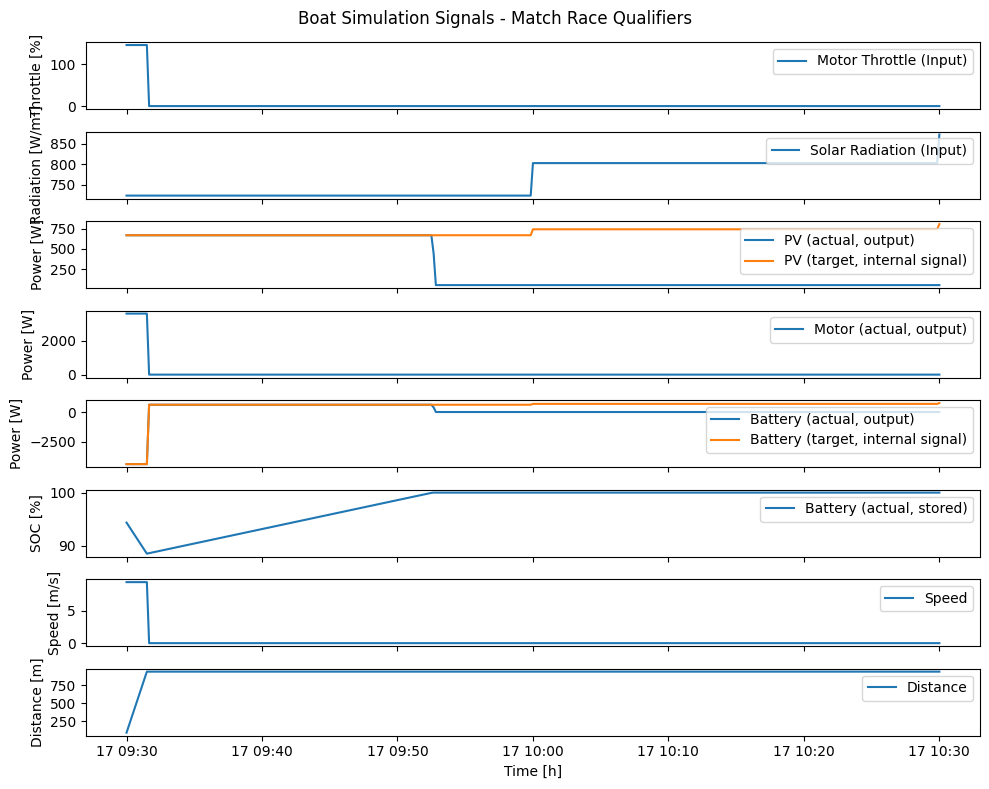

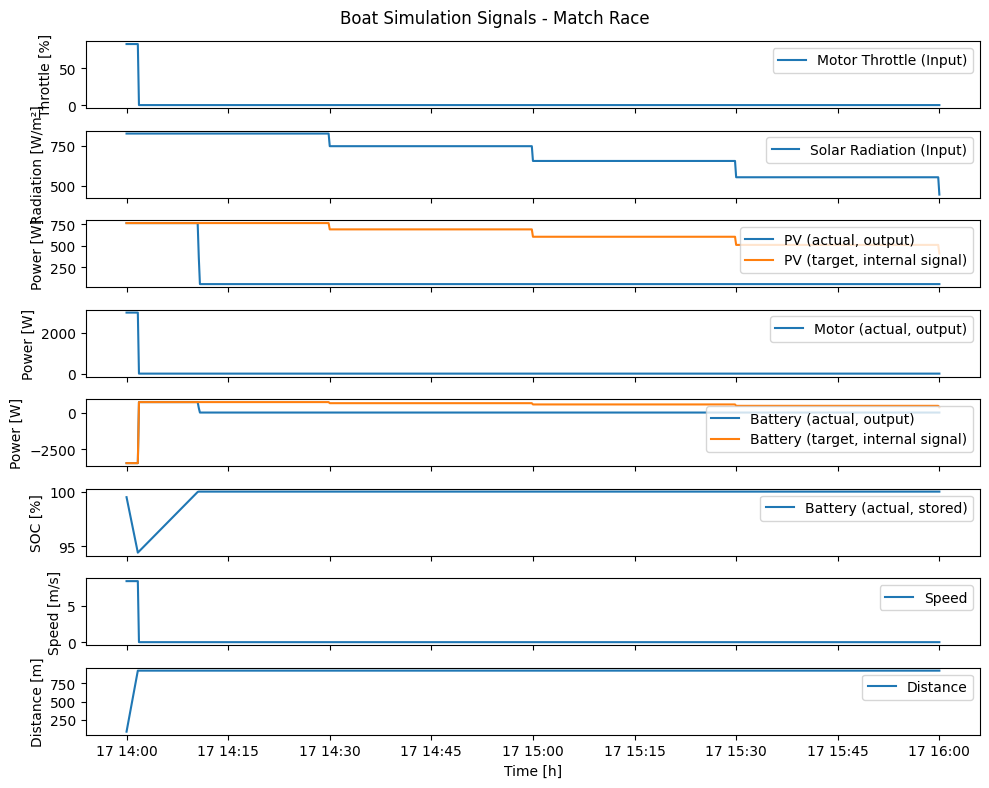

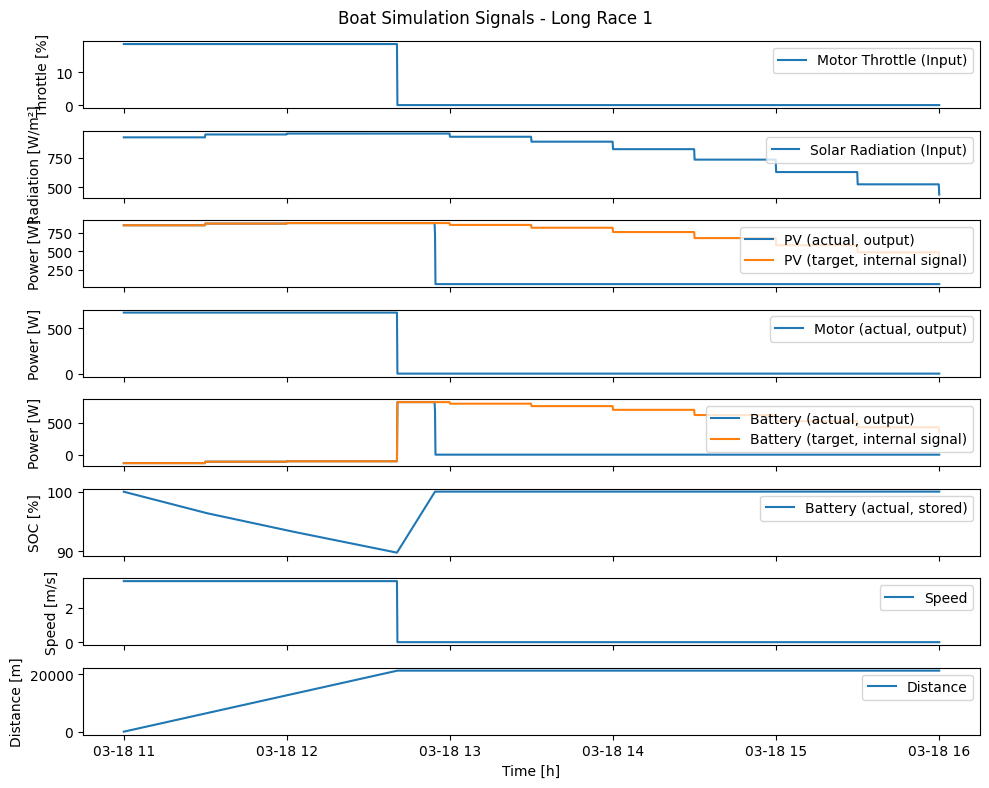

In [6]:
# Plot the simulation

for result in competition_result.results:

    fig, axs = plt.subplots(8, figsize=(10, 8 * 1.0), sharex=True, sharey=False)

    result_input_data = result.input_data.to_dataframe().set_index('time').tz_localize('GMT').tz_convert(tzinfo).reset_index(drop=False)
    result_output_data = result.output_data.to_dataframe()

    axs[0].plot(
        result_input_data.time,
        result_output_data.motor_target_throttle * 100,
        label="Motor Throttle (Input)",
    )
    axs[0].legend(loc="upper right")
    axs[0].set_ylabel("Throttle [%]")

    axs[1].plot(
        result_input_data.time,
        result_input_data.poa,
        label="Solar Radiation (Input)",
    )
    axs[1].legend(loc="upper right")
    axs[1].set_ylabel("Radiation [W/m²]")

    axs[2].plot(
        result_input_data.time,
        result_output_data.pv_output_power,
        label="PV (actual, output)",
    )
    axs[2].plot(
        result_input_data.time,
        result_output_data.pv_target_power,
        label="PV (target, internal signal)",
    )
    axs[2].legend(loc="upper right")
    axs[2].set_ylabel("Power [W]")

    axs[3].plot(
        result_input_data.time,
        result_output_data.motor_output_power,
        label="Motor (actual, output)",
    )
    # axs[3].plot(
    #     result_input_data.time,
    #     result_output_data.motor_target_power,
    #     label="Motor (target, internal signal)",
    # )
    axs[3].legend(loc="upper right")
    axs[3].set_ylabel("Power [W]")

    axs[4].plot(
        result_input_data.time,
        result_output_data.battery_output_power,
        label="Battery (actual, output)",
    )
    axs[4].plot(
        result_input_data.time,
        result_output_data.battery_target_power,
        label="Battery (target, internal signal)",
    )
    axs[4].legend(loc="upper right")
    axs[4].set_ylabel("Power [W]")

    axs[5].plot(
        result_input_data.time,
        result_output_data.battery_soc * 100,
        label="Battery (actual, stored)",
    )
    axs[5].legend(loc="upper right")
    axs[5].set_ylabel("SOC [%]")

    axs[6].plot(
        result_input_data.time,
        result_output_data.hull_speed,
        label="Speed",
    )
    axs[6].legend(loc="upper right")
    axs[6].set_ylabel("Speed [m/s]")

    axs[7].plot(
        result_input_data.time,
        result.event_result.distance,
        label="Distance",
    )
    axs[7].legend(loc="upper right")
    axs[7].set_ylabel("Distance [m]")

    plt.xlabel("Time [h]")
    plt.suptitle(f"Boat Simulation Signals - {result.name}")
    plt.tight_layout()
    plt.show()
